# День пятый - интерпретация, внедрение и другие темы

Сегодня нас ждут:
- некоторые методы локальной интерпретации
- как создать веб-сервис на `flask`, как сохранить и загрузить модель
- презентация `jupyter notebooks` на `voila` и немного `streamlit`
- элементы мониторинга после внедрения

факультативно:
- немного о вероятностном программировании
- вариационные автокодировщики (будем генерировать картинки).

## 5.1 Методы интерпретации

Как ранее уже упоминалось, методы интерпретации модели могут быть глобальными (как важность признаков у деревьев), а могут быть локальными, то есть теми, которые объясняют почему предсказание для конкретного примера именно такое.

Сейчас мы рассмотрим библиотеку `shap` (`SHapely Additive exPlanations`, где в названии, *Shapely* - это фамилия), которая такие предсказания и позволяет делать. И делает это она благодаря некоторым результатам из теории игр.

Представим себе признаки как игроков, а результат "игры" - это предсказание модели для этих признаков (разово). Тогда `shap` позволяет судить о вкладе каждого игрока в "выигрыш" (предсказание) - для этого рассматривается каждый поднабор из всех признаков (сочетания), от нуля признаков до всех, и для каждого поднабора учится своя модель. При добавлении признака в набор, он даёт некоторый вклад (эффект) в предсказание. Все эффекты для вхождений каждого признака количественно взвешиваются, они есть итоговый эффект каждого признака.

А теперь представьте что у нас (всего) 10 признаков, это означает что нам надо перебрать `2**10` моделей (с различными наборами признаков). Мы, конечно, этим заниматься не будем, и благодаря библиотеке `shap`, умеющей во всевозможные оптимизации подобных вычислений и прочие ухищрения, всё получается быстрее.

In [1]:
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# загрузим датасет ракушек
data = pd.read_csv('data/abalone.csv')

# немного препроцессинга
data['sex'] = data.sex.apply(lambda sex: {
    'F': 0, 'M': 1, 'I': 2
}[sex])

data.sample(3)

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
2060,1,0.50,0.390,0.135,0.7815,0.361,0.1575,0.2385,9
2644,2,0.49,0.375,0.125,0.5445,0.279,0.1150,0.1300,8
2587,0,0.57,0.445,0.150,0.9950,0.504,0.1850,0.2505,9


In [2]:
import shap

Библиотека `shap` может объяснять модели на базе деревьев (`TreeExplainer`), линейные (`LinearExplainer`, требуются независимые - они же несвязанные - признаки), нейронные сети `keras` (`DeepExplainer`), а также произвольные модели (`KernelExplainer`) - но увы весьма медленно.

На данный момент, `TreeExplainer` не умеет в мультикласс, поэтом в этих случаях надо пользоваться универсальным `KernelExplainer`, и следует отметить, что он требует чтобы у модели был метод `predict_proba` (предсказывает вероятность - или уверенность - в классе). Таким методом обладают, например, все деревья.

Мы же пока тем временем попробуем объяснить результаты работы регрессора.

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

# отложим 100 сэмплов
indices = shuffle(list(range(len(data))), random_state=1)
train = indices[:-100]
test = indices[-100:]

regressor = GradientBoostingRegressor(
    n_estimators=15, max_depth=7, random_state=1
).fit(data.iloc[train,:-1], data.iloc[train, -1])

print("test score %.3f" % regressor.score(
    data.iloc[test,:-1], data.iloc[test, -1]
))

explainer = shap.TreeExplainer(regressor, data=data.iloc[test, :-1])
shap_values_test = explainer.shap_values(data.iloc[test, :-1]);

test score 0.361


In [4]:
print('True rings value for first test sample = %d' % data.iloc[test[0], -1])

True rings value for first test sample = 11


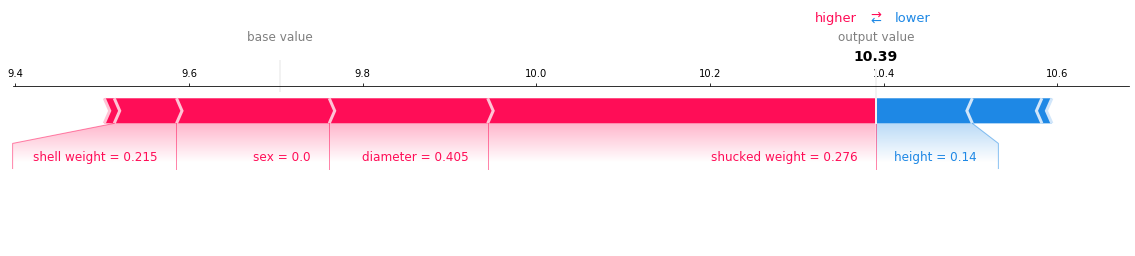

In [5]:
shap.force_plot(explainer.expected_value, shap_values_test[0], data.iloc[test[0],:-1], matplotlib=True)

На это диаграмме красным - то что добавило нам колец, а синим - то, что (для этой ракушки) убавило. Причем подписано сколько колец добавлено/убавлено. Лично я считаю, что для регрессии подобные объяснения очень наглядны. 

Для классификации есть же нечто, скажем так, поинтереснее, а именно `Alibi Trust Scores` - уровни доверия. Это мера соответствия между предсказанным классом, и тем, какие ближайшие соседи у этого класса. Условно, если предсказанный класс примера находится рядом с множеством подобных - тем больше мы можем верить предсказанию. А если не условно, то это по аналогии с `silhoutte_score` - отношение между расстоянием до ближайшего класса, отличного от предсказанного, к расстоянию до предсказанного класса. Следовательно, если эта величина больше 1, и чем она вообще больше, тем больше доверия к предсказанию.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(
    n_estimators=15, max_depth=3, random_state=1
).fit(data.iloc[train,1:], data.iloc[train, 0])

print("test score %.3f" % classifier.score(
    data.iloc[test,1:], data.iloc[test, 0]
))

test score 0.580


In [7]:
from alibi.confidence import TrustScore
ts = TrustScore(
    # тут могут быть настройки, но мы
    # оставим всё по умолчанию
)

ts.fit(
    data.iloc[train,1:].values,
    data.iloc[train, 0].values,
    classes=3
)

In [8]:
predicted = classifier.predict([data.iloc[test[0], 1:]])[0]
print("True class %d, predicted %d" % (
    data.iloc[test[0], 0],
    predicted
))

trust_scores, closest_classes = ts.score(
    np.array([data.iloc[test[0], 1:]]),
    np.array([predicted])
)

print("Proba %.3f, TrustScore %.3f, closest class %d" % (
    classifier.predict_proba(
        data.iloc[test[0], 1:].values.reshape(1, -1)
    )[0][0],
    trust_scores[0], closest_classes[0]
))

True class 0, predicted 2
Proba 0.330, TrustScore 0.745, closest class 0


Тут видим, `trust score < 1` , и ближайший класс точнее. Впрочем, здесь и вероятность предсказания не самая высокая (да и классификатор так себе).

А сейчас мы рассмотрим технику, которая позволяет одновременно отбирать признаки и строить некоторую интерпретацию вида "мы тут можем ошибаться на столько-то" (*model perfomance prediction*). Нужно построить регрессор (в случае классификации - классификатор), который будет обучен (на отложенной валидации, поскольку стэкинг) предсказывать ошибки алгоритма.

Посмотрим на эту позаимствованную (получается уже дважды) картинку.
![MPP](media/mpp.png)

In [9]:
indices = shuffle(list(range(len(data))), random_state=1)
train = indices[:-2000]
val = indices[-2000:-1000]
test = indices[-1000:]

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.pipeline import make_pipeline

preprocessor_regression = make_pipeline(PowerTransformer(), PolynomialFeatures(degree=3))
X_regression_train = preprocessor_regression.fit_transform(data.iloc[train,1:-1])
X_regression_val = preprocessor_regression.transform(data.iloc[val,1:-1])
X_regression_test = preprocessor_regression.transform(data.iloc[test,1:-1])

preprocessor_classification = make_pipeline(PowerTransformer(), PolynomialFeatures(degree=3))
X_classification_train = preprocessor_classification.fit_transform(data.iloc[train,1:])
X_classification_val = preprocessor_classification.transform(data.iloc[val,1:])
X_classification_test = preprocessor_classification.transform(data.iloc[test,1:])

regressor = Ridge(random_state=1).fit(
    X_regression_train, data.iloc[train, -1]
)

classifier = LogisticRegression(random_state=1).fit(
    X_classification_train, data.iloc[train, 0]
)

print("simple: r2 %.3f, acc %.3f" % (
    regressor.score(X_regression_test, data.iloc[test, -1]),
    classifier.score(X_classification_test, data.iloc[test, 0])
))

simple: r2 0.526, acc 0.528


In [10]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

def get_error_models(regression_features, classifier_features):
    error_regressor = GradientBoostingRegressor(
        n_estimators=30, max_depth=5, random_state=1
    ).fit(
        X_regression_val[:, regression_features],
        np.abs(
            regressor.predict(X_regression_val[:, regression_features]) - data.iloc[val,-1]
        )
    )

    error_classifier = GradientBoostingClassifier(
        n_estimators=30, max_depth=5, random_state=1
    ).fit(
        X_classification_val[:, classifier_features],
        (
            classifier.predict(X_classification_val[:, classifier_features]) != data.iloc[val,0]
        ).astype(int)
    )
    return error_regressor, error_classifier

error_regressor, error_classifier = get_error_models(
    regression_features=slice(None),
    classifier_features=slice(None)
)

Мы получили регрессор ошибки и классификатор ошибки. Их можно использовать и для отбора признаков (в обоих случаях уберем несколько неважных признаков и посмотрим), и для проверки корректности предсказания.

In [11]:
redundand = 10

regressor_features = np.argsort(error_regressor.feature_importances_)[redundand:]
classifier_features = np.argsort(error_classifier.feature_importances_)[redundand:]

regressor = Ridge(random_state=1).fit(
    X_regression_train[:, regressor_features], 
    data.iloc[train, -1]
)

classifier = LogisticRegression(random_state=1).fit(
    X_classification_train[:, classifier_features],
    data.iloc[train, :1]
)

print("selected: r2 %.3f, acc %.3f" % (
    regressor.score(X_regression_test[:, regressor_features], data.iloc[test, -1]),
    classifier.score(X_classification_test[:, classifier_features], data.iloc[test,0])
))

selected: r2 0.540, acc 0.537


В данном случае мы убрали признаки, которые давали *наименьший вклад в объяснение ошибки*. Это означает, что они имеют слабое влияния на то, как предсказывает изначальная модель. Давайте посмотрим на ошибку предсказания для конкретного примера.

In [12]:
error_regressor, error_classifier = get_error_models(
    regressor_features, classifier_features
)

print("regression: True %d, Predicted %.2f, error %.3f" % (
    data.iloc[test[0], -1],
    regressor.predict([X_regression_test[0, regressor_features]])[0],
    error_regressor.predict([X_regression_test[0, regressor_features]])[0]
))

print("classification: True %s, Predicted %s, is error %s" % (
    str(data.iloc[test[0], 0].astype(int)),
    str(classifier.predict([X_classification_test[0, classifier_features]])[0]),
    str(error_classifier.predict([X_classification_test[0, classifier_features]])[0])
))

regression: True 14, Predicted 12.94, error 1.722
classification: True 1, Predicted 0, is error 1


## В качестве заключения

Не всегда модели всё делают автоматически (вместо людей). Часто, и особенно на сложных производствах - модели лишь рекомендуют некоторый режим или настройки технологических процессов. И когда человек принимает решение в конкретный момент времени, ему хотелось бы знать, почему именно такое предсказание выдала модель, потому что "черным ящикам" не доверяют - несмотря на все метрики и кросс-валидации (так устроен человек). Поэтому если есть объяснение предсказанию, или степень уверенности - это важная дополнительная информация для человека, который будет принимать решение.

## 5.2 Развертывание моделей

После создания модели, хотелось бы её применять. Очень часто модели оформляют в виде *микросервисов* - то есть обособленного приложения (или веб-приложения), которому на вход подаются признаки, а на выходе оно отдаёт предсказание. Преимущество такого подхода очевидно - мы можем подставить более лучшую модель, например, не изменяя всех остальных частей сайта, настольного или мобильного приложения.

Веб-сервис - это некоторая программа, которая принимает по протоколу `HTTP`/`HTTPS` в некотором формате (обычно `JSON` - `JavaScript Object Notation`) входные данные, и в том же формате их отдает. Но для начала, модель необходимо *сериализовать* (сохранить например в файл), а при запуске сервиса - *десериализовать* (загрузить из файла).

Модели `scikit-learn` могут быть сериализованы встроенными средствами python - модулем `pickle`, который умеет сохранять python-объекты в файл. Для `keras` необходимо использовать методы `save`/`load`.

```python

model = keras.Model()
filepath = 'path/to/filename.h5'

# ...

# метод save
model.save(filepath)

model = keras.models.load_model(filepath)
```

В четвертом дне был пример загрузки модели для `keras`, мы рассмотрим пример для `scikit-learn`, и возьмем датасет нарисованных чисел. В нём 10 цифр по около 180 раз, размером 8х8.

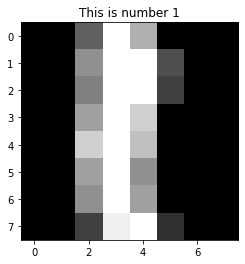

In [13]:
from sklearn.datasets import load_digits

X, y = shuffle(*load_digits(return_X_y=True), random_state=1)

plt.title("This is number %d" % y[0])
plt.imshow(X[0].reshape(8, 8), cmap='gray');

In [14]:
X.max()

16.0

In [15]:
from sklearn.neural_network import MLPClassifier

def preprocess_samples(samples):
    return samples / X.max()

train = int(len(y) * 0.8)

digitizer = MLPClassifier([32, 16], random_state=1).fit(
    preprocess_samples(X[:train]), y[:train]
)

"Accuracy score %.3f" % digitizer.score(
    preprocess_samples(X[train:]), y[train:]
)

'Accuracy score 0.958'

In [16]:
# теперь сохраним всё в файл
import pickle

with open('models/digitizer.pickle', 'wb') as fd:
    # wb - write binary
    pickle.dump({
        'scale': X.max(),
        'model': digitizer
    }, file=fd)

Сервер выглядит вот так (код можно найти в `code/digitzer_service.py`).

```python
from flask import Flask, request, jsonify
app = Flask(__name__)

import pickle
with open('../models/digitizer.pickle', 'rb') as fd:
    methods = pickle.load(fd)
    
scale = methods['scale']
model = methods['model']

import numpy as np
from json import loads

@app.route('/', methods=['POST'])
def index():
    data = loads(request.json)
    result = {
        'prediction': int(
            model.predict(
                np.array([data]).astype(float) / scale
            )[0]
        )
    }
    return jsonify(result)

# файл запустили напрямую
if __name__ == '__main__':
    app.run(host='localhost', port=5555, debug=True)

```

Его необходимо запустить отдельно (например через `python3 digitizer_service.py`), чтобы протестировать.

In [17]:
import json, requests

response = requests.post('http://localhost:5555/', json=json.dumps(X[-1].tolist()))
json.loads(response.content), {'true label': y[-1]}

({'prediction': 5}, {'true label': 5})

## Заключение

Это далеко не всё из того, как можно было бы делать - но вполне себе начало. Благодаря HTTP-запросам, можно обращаться к модели откуда угодно, хоть из браузера (из адресной строки он отправляет `GET`-запрос). Аналогично, микросервис может быть просто `.bat`-файлом - в случае ОС Windows - который запустит python-скрипт, который в свою очередь уже всё сделает. Однако это менее производительный метод, так как каждый раз будет загружаться модель.

## 5.3 Презентация моделей

Мы рассмотрим два метода - `voila` и `streamlit`.

- `voila` - это пакет, позволяющий одной командой запустить `jupyter notebook` (без отображения кода по умолчанию) как интерактивную веб-страницу,
- `streamlit` - это пакет, позволяющий без помощи `jupyter` создавать интерактивные веб-страницы с помощью скриптов прямо на `python`.

Если первый метод прост, то второй метод - это вполне себе замена `jupyter notebooks`, и в последнее время всё более распространяется среди аналитиков данных. По-крайней мере для целей презентации результатов уж точно.

Загляните в директорию `code` - там есть тетрадка под названием `voila_example.ipynb`, её можно запустить с помощью команды `voila code/voila_example.ipynb`. Обратите внимание, что интерактивные виджеты в ней так же будут работать.

Выглядеть это будет примерно так.

![voiled](media/voila_example.png)

А теперь откройте файл `code/streamlit_example.py` - и запустите его командой `streamlit run code/streamlit_example.py`

И выглядеть это будет около того.

![streamlited](media/streamlit_example.png)

## Заключение

Если python - не особо большая проблема - очень рекомендую пользоваться `streamlit` - у него в арсенале не только всевозможные элементы управления (чекбоксы, слайдеры, кнопки и др.), но и всевозможные способы отображения данных: таблицы, множество диаграмм (не только `matplotlib`!), встроена возможность отображать географические карты, и многое-многое другое.

Если надо быстро и просто - можно пользоваться `voila`.

## 5.4 A/B-тестирование

Представьте, что вы создали и развернули модель, но пока не запустили. Когда запустите, будет ли известно, стало лучше или нет? Правильный ответ на этот вопрос - зависит от того, как часто она будет срабатывать по отношению к имеющемуся процессу.

Представим, у нас есть процесс определения сорта ириса на глаз, и с помощью модели. 

> Нельзя сравнивать бизнес-метрики ДО и ПОСЛЕ запуска модели! Можно только С и БЕЗ модели!

Это правило на самом деле из управления реальными инвестиционными проектами. Неправильно задаваться вопросом, лучше ли будет после реализации проекта или нет - правильно задаваться вопросом, будет ли лучше с проектом? Эффект от проекта - это как раз разница между ситуациями "с проектом" и "без проекта".

С моделями аналогично: `эффект от модели = эффект с моделью - эффект без модели.`

Но что, если мы не знаем какой будет эффект с моделью? Мы можем выделить некоторое подмножество примеров в процессе, которые будут обрабатываться моделью, а остальные как прежде. Те, которые будут обрабатываться как прежде - называются **контрольной группой**, а те что по-новому - **тестовой группой**. Поэтому и A/B-тестирование (хотя бывает еще и A/B/C- и A/B/C/D... - A/B/n - и с этим всё немного сложнее, и нужно реже).

Поскольку тестовая и контрольная группа по размерам могут быть (и обычно) разные, мы не можем напрямую сравнивать количество или даже процент ошибок.

In [18]:
control_size = 5000
control_errors = 1000

test_size = 2000
test_errors = 380

print("error rate control %.2f, test %.2f" % (
    control_errors / control_size, test_errors / test_size
))

error rate control 0.20, test 0.19


В таком виде делать заключение - это практически наугад, так как на маленькой выборке (тестовой в данном случае) - было мало данных, и мало ли какие хорошие или плохие они там были (то есть выборка могла быть *нерепрезентативной*).

Сейчас сделаем Байесовский калькулятор, который скажет, какой вариант всё же лучше. Почему Байесовский? Потому что в Байесовском подходе ответ - это распределение величин, а не точечные оценки ("да", или "12.5"). А на распределениях можно будет уже навести некоторую аналитику.

Чтобы её сделать, мы должны найти распределение самой вероятности ошибки, то есть рассмотреть процент ошибок как случайную величину.

К счастью, из теории вероятностей мы можем узнать:
1. есть случайные величины (Бернулли), которые принимают 0 или 1, причем 1 с вероятностью q,
2. для последовательности длиной `n` таких величин с вероятностью "успеха" (в нашем случае ошибки) равной `q` есть распределение под названием *биномиальное*, которое описывает количество "успехов" по отношению к общему числу,
3. в свою очередь, существует распределение (*Beta-распределение*), такое что для серии испытаний длиной `n` с вероятностью "успеха" каждого `q`, верно, что `q` распределена как `Beta`.

Количество ошибок и количество правильных - параметры $\alpha$ и $\beta$. При этом `Beta(1, 1)` эквивалентно равномерному распределению - то есть за один эксперимент равновероятно любое значение. Отметим, что его мат. ожидание $E = \frac {\alpha} {\alpha + \beta}$.

Подытоживая, процент ошибки у нас распределен как `Beta(errors + 1, correct + 1)` - единицу добавляем до всяких экспериментов как *априорное знание*. *Beta-распределение* - это такое распределение, что после применения теоремы Байеса мы получим то же распределение с другими параметрами. Это очень замечательно, ведь нам не придется вычислять напрямую, и будет:

$$P(q) = Beta(\alpha, \beta) => P(q | e, c) = Beta(\alpha + e, \beta + c),$$ где `e` - новые ошибки, `c` - новые корректные примеры.

Проверим непосредственными испытаниями нашу концепцию.

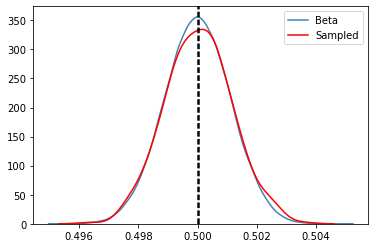

In [19]:
def check_distribution(errors, correct):
    np.random.seed(1)
    
    # случайные вероятности "успеха", пусть 100 миллионов
    percents = np.random.uniform(size=10 ** 8)
    
    # биномиальное распределение, длина серии = ошибки + корректные
    trials = np.random.binomial(n=errors + correct, p=percents)
    
    # посмотрим для сравнения сразу Beta-распределение
    beta_samples = np.random.beta(errors + 1, correct + 1, size=10 ** 5)
    sns.distplot(beta_samples, hist=False, label="Beta", color='steelblue')
    
    # выберем проценты, которые дают то же количество ошибок из общего числа
    samples = percents[
        np.where(trials == errors)
    ]
    
    # и отобразим распределение этих процентов
    sns.distplot(samples, hist=False, label="Sampled", color='red')
    
    plt.axvline(beta_samples.mean(), 0, 1, ls='--', c='black')
    plt.axvline(samples.mean(), 0, 1, ls='--', c='black')
    
    plt.legend(loc='best');
    
# запустим по 100 тысяч успехов и неуспехов
check_distribution(10 ** 5, 10 ** 5)

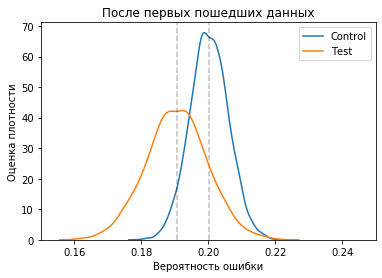

In [20]:
def plot_beta(errors, correct, label, samples=None):
    np.random.seed(1)
    
    X = np.random.beta(errors + 1, correct + 1, size=(errors + correct) if samples is None else samples)
    sns.distplot(X, hist=False, label=label)
    plt.axvline(X.mean(), 0, 1, ls='--', c='black', alpha=0.25)
    
    plt.xlim(0.15, 0.25)
    plt.xlabel('Вероятность ошибки')
    plt.ylabel('Оценка плотности');

plt.title("После первых пошедших данных")
plot_beta(control_errors, control_size - control_errors, 'Control')
plot_beta(test_errors, test_size - test_errors, 'Test')

Вот из этой-то картинки видно, что несмотря на схожесть средних процентов, уверенности в том что вариант с моделью лучше - у нас не так уж и много. Так что же делать? Продолжать, пока не станем уверенными в различиях.

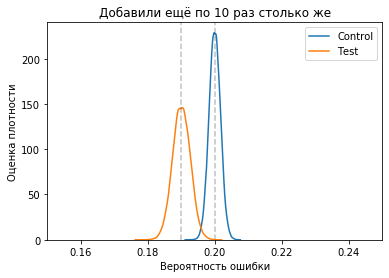

In [21]:
rescale = 10

new_control_errors = control_errors * rescale
new_control_size = control_size * rescale

new_test_errors = test_errors * rescale
new_test_size = test_size * rescale

plt.title("Добавили ещё по %d раз столько же" % rescale)
plot_beta(control_errors + new_control_errors, control_size + new_control_size - control_errors - new_control_errors, 'Control')
plot_beta(test_errors + new_test_errors, test_size + new_test_size - test_errors - new_test_errors, 'Test')

Здесь уже всё выглядит так, что тестовый вариант с моделью определенно лучше. Тем не менее, всё еще остаётся некоторый шанс, что выбрав вариант с моделью, он не будет лучше - так как наши апостериорные распределения пересекаются.

Можно конечно пытаться подсчитать, сколько нужно примеров чтобы распределения разошлись "как в море корабли" (так бывает и делают), а можно выбрать некоторый интервал уверенности, например что пересечение менее 1% незначимо.

## Заключение 

Машинное обучение - как раз для того и нужно, чтобы улучшать процессы. По факту же не всякая модель улучшает. Прояснить, улучшает или нет можно A/B-тестированием. Часто после того, как убедятся в том что вариант с моделью лучше, контрольную выборку делают очень маленькой. Или совсем убирают, когда есть дополнительные метрики для мониторинга эффекта процесса в целом.

# 5.5 Вероятностное программирование

Суть вероятностного программирования - найти не точечные оценки на параметры моделей, а найти их распределение. Делается это, в целом, алгоритмом, похожим на следующее:
1. Взять некоторую начальную позицию (значение каждого параметра),
2. Найти некоторое значение неподалёку от него,
3. Принять или отбросить значение шага 2 в зависимости от того, насколько оно связано с данными и нашими априорными представлениями об их значениях,
4. Если приняли - запомнить, если отбросили - пропустить значение. Перейти на шаг 1.
5. После заданного числа итераций, вернуть все запомненные позиции.

Запомненные позиции в вероятностном программировании называются *samples* (примеры), а их последовательности - *traces* (следы). Как можно отметить, алгоритм не учитывает все предыдущие шаги, а только текущий (то есть "без памяти"). Для сэмпла важно значение, а не путь. И чем случайнее ("перемешаннее") этот путь - тем лучше!

Полученные сэмплы дают некоторое приближение к апостериорному распределению, тому которое нас интересует (оно больше соответствует данным, нежели наше априорное). Что делать с этими сэмплами и следами, давайте посмотрим на примере.

In [1]:
%matplotlib inline

# локальные хаки, могут быть не нужны
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

import pymc3
pymc3.__version__

'3.9.2'

In [2]:
data = shuffle(pd.read_csv('data/abalone.csv'), random_state=1)
male = data[data.sex == 'M'].drop('sex', axis='columns')

# возьмемся предсказывать количество колец
target = 'rings'

train = male[:2 * len(male) // 3]
test = male[2 * len(male) // 3:]

print('Males', len(male), 'Test size', len(test))

Males 1528 Test size 510


До текущего момента предполагается всё ясно. Дальше начнется та самая магия статистического вывода.

Мы предположим, что количество колец - это дискретная случайная величина с распределением Пуассона. Оно имеет один параметр, и мат. ожидание равно этому параметру (равно как дисперсия). Обычно распределением Пуассона моделируют количество событий за определенный промежуток времени. За события мы будем считать появление колец.

Далее, мы смоделируем среднее количество колец как величину, линейно зависимую от полного веса ракушки и её диаметра. То есть наша модель, это, очень грубо говоря, "в среднем число колец - это функция диаметра и веса". Но случайность допускает отклонения.

Параметры линейной зависимости мы *не знаем*, но мы выведем их *распределение* из данных путем *сэмплирования*.

In [3]:
def analyze_data(data):
    model = pymc3.Model()
    
    with model:
        # распределения коэффициентов линейной модели
        # mu - среднее, sd - разброс. Это всё приоры
        
        alpha = pymc3.Normal('alpha', mu=train[target].mean() / 2 / train['diameter'].mean(), sd=1)
        beta =  pymc3.Normal('beta', mu=train[target].mean() / 2 / train['whole weight'].mean(), sd=1)
        
        # свободное слагаемое в линейной модели будет с некоторым неизвестным разбросом
        # мы получаем иерархическую модель. Экспоненциальное распределение - со средним 1 / lambda,
        # моделирует неотрицательную вещественную величину с убывающей вероятностью больших значений
        
        sd = pymc3.Exponential('deviation', lam=1 / 3)
        gamma = pymc3.Normal('gamma', mu=0, sd=sd)
        
        estimate = alpha * train['diameter'] + beta * train['whole weight'] + gamma
        observed = pymc3.Poisson('rings', mu=estimate, observed=train[target])
        
        # MAP - maximum aposteriori - это попытка найти хорошую стартовую точку для начала сэмплирования        
        MAP = pymc3.find_MAP()
        
        # tune - число "разогревочных" сэмплов, мы их рассматривать не будем
        traces = pymc3.sample(draws=500, tune=500, start=MAP, discard_tuned_samples=True, cores=2, chains=2)
    
    # поскольку у нас 2 цепочки по 500, в каждом следе мы возьмем каждый второй сэмпл, чтобы снизить влияние зависимости следующего от предыдущего
    predictions = traces['alpha'][::4].mean() * test['diameter'] + traces['beta'][::4].mean() * test['whole weight'] + traces['gamma'][::4].mean()
    return model, traces, mean_absolute_error(test[target], predictions)

male_model, male_traces, male_mae = analyze_data(male)
print("TEST MAE: %.1f" % male_mae)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gamma, deviation, beta, alpha]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 83 seconds.
The acceptance probability does not match the target. It is 0.8927451395035267, but should be close to 0.8. Try to increase the number of tuning steps.


TEST MAE: 2.2


Итак, мы получили множество значений параметров. Можно посмотреть, насколько хорошо процедура их вывода сработала. Чем более случайно перемешаны параметры - тем лучше. Цветами на распределении параметров отображаются разные цепочки следов.

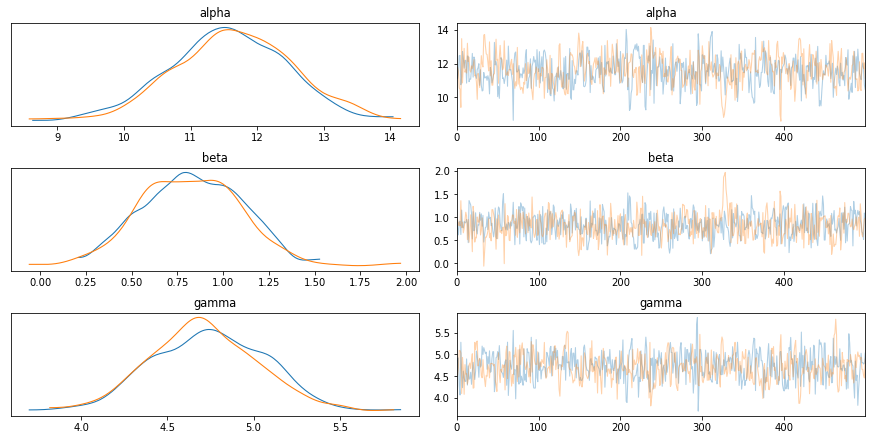

In [4]:
with male_model:
    pymc3.plot_trace(male_traces, var_names=['alpha', 'beta', 'gamma']);

Всё это конечно хорошо, но что делать со всей этой кучей параметров?

На самом деле благодаря ним, мы теперь знаем как распределено количество колец и можем моделировать фактически сам *data generation process*. В коде ниже определяются некоторые границы для большинства ракушек путем операций над сэмплированными параметрами. 

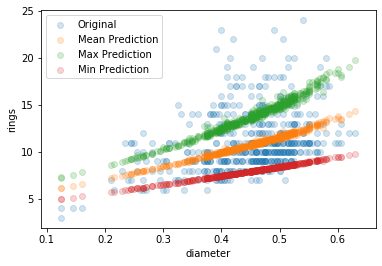

In [5]:
def male_predict(data, operation=np.mean, randomize=False):
    np.random.seed(1)
    alpha = operation(male_traces['alpha'][::4])
    beta = operation(male_traces['beta'][::4])
    gamma = operation(male_traces['gamma'][::4])
    mean = alpha * data['diameter'] + beta * data['whole weight'] + gamma
    if randomize:
        return np.random.poisson(lam=mean)
    return mean

plt.scatter(test.diameter, test[target], alpha=0.2, label='Original');
plt.scatter(test.diameter, male_predict(test), alpha=0.2, label='Mean Prediction');
plt.scatter(test.diameter, male_predict(test, operation=np.max), alpha=0.2, label='Max Prediction');
plt.scatter(test.diameter, male_predict(test, operation=np.min), alpha=0.2, label='Min Prediction');
plt.xlabel('diameter');
plt.ylabel('rings');
plt.legend(loc='best');

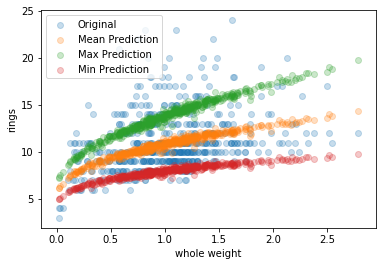

In [6]:
plt.scatter(test['whole weight'], test[target], alpha=0.25, label='Original');
plt.scatter(test['whole weight'], male_predict(test), alpha=0.25, label='Mean Prediction');
plt.scatter(test['whole weight'], male_predict(test, operation=np.max), alpha=0.25, label='Max Prediction');
plt.scatter(test['whole weight'], male_predict(test, operation=np.min), alpha=0.25, label='Min Prediction');
plt.xlabel('whole weight');
plt.ylabel('rings');
plt.legend(loc='best');

Но на самом деле, параметры параметрами, а целевая величина у нас случайная. И мы можем получать её (случайные) значения. Можем даже просто выбирая случайные значения параметров.

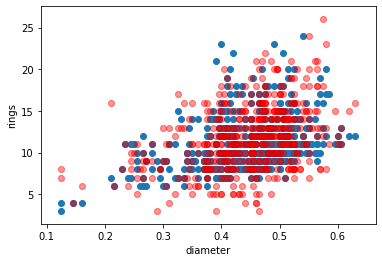

In [7]:
plt.scatter(test['diameter'], test[target], label='Original')
for _ in range(10):
    plt.scatter(test['diameter'], male_predict(test, operation=np.random.choice, randomize=True), c='red', alpha=0.05);
plt.xlabel('diameter');
plt.ylabel('rings');

Теперь мы по сути знаем, какие могут быть ракушки вообще - потому что (например на тестовом множестве) не всегда встречаются абсолютно все значения. В примере ниже выбираются даже не все параметры, а только те, которые лежат в интервале от 10 до 90 процентов всех значений.

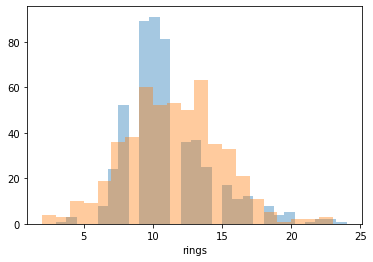

In [8]:
sns.distplot(test[target], kde=False, hist=True);
sns.distplot(
    male_predict(
        test,
        lambda array: np.mean(
            np.clip(
                array,
                np.percentile(array, 10),
                np.percentile(array, 90)
            )
        ),
        randomize=True
    ),
    kde=False,
    hist=True
);

Так всё же зачем нужно вероятностное программирование? Оно нужно не для того чтобы просто построить модель с точечными параметрами. Оно нужно чтобы исследовать - даже простыми линейными соображениями - как связаны данные с точки зрения (неслучайной) случайности.

В итоге можно спрогнозировать не один ответ, а найти интервальные оценки, вероятность что ответ будет каким-то конкретным. Не так уж и плохо. А по факту - бывает очень полезно в бизнесе, когда сценарный анализ с вероятностями позволяет найти, скажем, области убытков.

# 5.6 Генеративные задачи

В дне 4, блоке 2, мы рассматривали автокодировщики (с шумоподавлением, их даже можно применять для рекомендаций). Они укладывали в примеры в некоторое векторное пространство. 

То векторное пространство не обладало некоторыми хорошими свойствами - в одно области можно было найти как и "штаны", так и "сандали" датасета `fashion mnist`. Поэтому, выбрав случайную точку в этом пространстве, мы бы не смогли предугадать, что бы мы получили на выходе.

Исправить эту ситуацию можно с применением условных вариационных автокодировщиков. Условный - означает что мы будем подавать целевую метку, помимо примера, а вариационный означает что примеры будут укладываться в вероятностное (нормально распределенное) пространство, и кодирующая часть будет предсказывать его среднее и разброс, а декодирующая - восстанавливать из него.

Самое сложное в этом деле - это следующие две вещи:
1. Мы не можем обучать сеть на случайных значениях, которые бы выдавала нам кодирующая часть (как считать производные?). Поэтому она предсказывает только среднее и разброс нормального распределение, и умножая на него и добавляя смещение, мы можем брать любой вектор из нормального стандартного `N(0, 1)` распределения. То есть декодирующая часть основывается не на случайном векторе от кодировщика, а на случайном из `N(0, 1)`, поправленным на предсказания кодировщика. Это так называемый `reparametrization trick`.
2. Если для выходных примеров мы можем использовать любые привычные потери (`mse` например, и другие), то для среднего и разброса мы должны специфицировать некоторую другую функцию потерь. Очень кратко - она базируется на сравнении (псевдо-) расстояния между распределениями ("расстояние Кульбака-Лейблера). Чем больше это расстояние - тем сильнее разнесены два распределения по пространству. Это нам нужно, чтобы непохожие примеры были как можно дальше друг от друга. В коде же будет использоваться уже результат сложных математических преобразований функции потерь.

In [1]:
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # -1 для СPU

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow
from tensorflow import keras
tensorflow.__version__, keras.__version__

('2.2.0', '2.3.0-tf')

In [2]:
import mnist

train_X, train_y, test_X, test_y = mnist.fashion_mnist()

train_X = np.expand_dims(train_X.astype(float), axis=-1) / 255.
test_X = np.expand_dims(test_X.astype(float), axis=-1) / 255.

train_y_categorical = keras.utils.to_categorical(train_y).astype(np.float32)
test_y_categorical = keras.utils.to_categorical(test_y).astype(np.float32)

fashion = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

print('X train shape', train_X.shape)

[MNIST] Caching data at C:\Users\Sazonov_AV\.local\share\FASHION_MNIST
[MNIST] Found http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz in cache.
[MNIST] Found http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz in cache.
[MNIST] Found http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz in cache.
[MNIST] Found http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz in cache.


X train shape (60000, 28, 28, 1)


In [3]:
keras.backend.clear_session()
batch_size = 100

class Sampler(keras.layers.Layer):    
    def call(self, inputs, **kwargs):
        mean, log_std = inputs
        
        batch = tensorflow.shape(mean)[0]
        dimension = tensorflow.shape(mean)[1]
        
        sample = tensorflow.random.normal(shape=(batch, dimension))
        return mean + tensorflow.exp(log_std / 2) * sample

class CVAE(keras.Model):
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def loss_function(self, image, transformed, space_mean, space_log_std, **kwargs):
        
        batch = tensorflow.shape(image)[0]
        output_size = tensorflow.multiply(
            tensorflow.shape(image)[1], tensorflow.shape(image)[2]
        )
        
        image = tensorflow.reshape(image, shape=(batch, output_size))
        transformed = tensorflow.reshape(transformed, shape=(batch, output_size))
        
        output_size = tensorflow.cast(output_size, tensorflow.float32)

        mse_loss = output_size * tensorflow.reduce_mean(
            keras.losses.mean_squared_error(image, transformed)
        )
        kld_loss = -0.5 * tensorflow.reduce_mean(
            1 + space_log_std - tensorflow.square(space_mean) - tensorflow.exp(space_log_std)
        )

        return mse_loss + kld_loss
    
    def train_step(self, data, **kwargs):
        if isinstance(data, tuple):
            image = data[0][0]
            label = data[0][1]
            target = data[0][2]
        with tensorflow.GradientTape() as tape:
            latent_space_mean, latent_space_log_std, latent_vector = self.encoder((image, label))
            reconstruction = self.decoder((latent_vector, target))
            loss_calculated = self.loss_function(
                image, reconstruction, latent_space_mean, latent_space_log_std
            )
        gradients = tape.gradient(loss_calculated, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        return {
            "loss": loss_calculated
        }
    
    def call(self, sample):
        latent_space_mean, latent_space_log_std, latent_vector = self.encoder(sample[:2])
        return self.decoder((latent_vector, sample[2]))
    
def create_model(batch_size=batch_size, input_shape=(28, 28, 1), number_classes=10, vector_size=3):
    
    output_size = 1
    for size in input_shape:
        output_size *= size
    
    input_image = keras.layers.Input(shape=input_shape)
    input_label = keras.layers.Input(shape=(number_classes,))
    
    layer = keras.layers.Flatten()(input_image)
    layer = keras.layers.concatenate([layer, input_label])
    layer = keras.layers.Dense(128, activation='elu')(layer)
    layer = keras.layers.Dense(32, activation='elu')(layer)
    
    latent_space_mean = keras.layers.Dense(vector_size)(layer)
    latent_space_log_std = keras.layers.Dense(vector_size)(layer)
    
    encoded = Sampler()([
        latent_space_mean, latent_space_log_std
    ])
    
    encoder = keras.Model(inputs=[input_image, input_label], outputs=[
        latent_space_mean, latent_space_log_std, encoded
    ])
    
    input_vector = keras.layers.Input(shape=(vector_size,))
    input_target = keras.layers.Input(shape=(number_classes,))
    
    layer = keras.layers.concatenate([input_vector, input_target])
    layer = keras.layers.Dense(32, activation='elu')(layer)
    layer = keras.layers.Dense(128, activation='elu')(layer)
    
    # sigmoid - так как мы знаем, что у нас градация серого на выходе
    decoded = keras.layers.Dense(output_size, activation='sigmoid')(layer)
    decoder = keras.Model(inputs=[input_vector, input_target], outputs=[decoded])
    
    cvae = CVAE(encoder, decoder)
    return cvae

cvae = create_model()
cvae.compile(optimizer='adam')

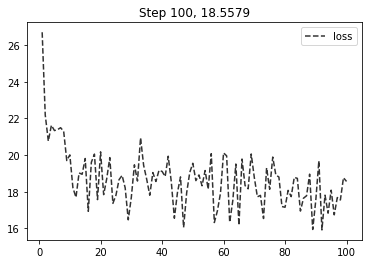

In [4]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        super(PlotLosses, self).__init__()
        self.logs = []
        self.losses = []        
        
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        self.logs.append(logs)
        x = range(1, len(self.logs) + 1)

        self.losses.append(logs.get('loss'))
        plt.plot(x, self.losses, ls='--', c='#323232', label='loss')
        plt.title("Step %d, %.4f" % (
            len(self.logs),
            logs.get('loss') or 0
        ))
        plt.legend(loc='best')        
        plt.show()

cvae.fit(
    (train_X, train_y_categorical, train_y_categorical),
    epochs=100, 
    batch_size=batch_size,
    verbose=0,
    callbacks=[PlotLosses()]
);

Отобразим то, как разошлись примеры по классам (разным классам - разные цвета). Для практических дел имеет смысл выбирать размерность скрытого пространства побольше, хотя бы 8. Тут 3 выбрано с целями полноты иллюстрации. И отбирать автокодировщик по валидации тоже хорошо.

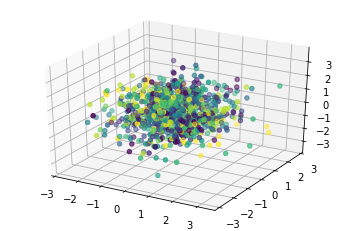

In [5]:
from mpl_toolkits.mplot3d import Axes3D
axes = plt.subplot(projection='3d')

def plot_label_clusters(cvae, images, labels, labels_categorical):
    mean, _, _ = cvae.encoder.predict([
        images, labels_categorical, labels_categorical
    ])
    axes.scatter(mean[:, 0], mean[:, 1], mean[:, 2], c=labels)
    
plot_label_clusters(
    cvae,
    test_X[:1000],
    test_y[:1000],
    test_y_categorical[:1000]
);

Теперь собственно то, ради чего всё затевалось - генерация нужных (и несуществующих) объектов.

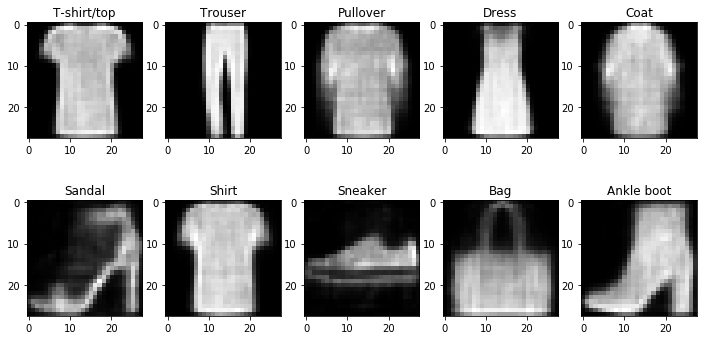

In [6]:
def unit_vector(target):
        result = [0.] * 10
        result[target] = 1.
        return np.array(result)
    
def plot_random_sample(cvae, target_class, ax, random_seed=1):
    np.random.seed(random_seed)
    random_vector = np.random.normal(0, 1, size=3)
    
    sample = cvae.decoder.predict([
        np.expand_dims(random_vector, axis=0), 
        np.expand_dims(unit_vector(target_class), axis=0)
    ])[0].reshape(28, 28)
    ax.set_title(fashion[target_class])
    ax.imshow(sample, cmap='gray');

plt.figure(figsize=(12, 6))
for index in range(1, 11):
    ax = plt.subplot(2, 5, index)
    plot_random_sample(cvae, index - 1, ax=ax)

Бонусом ко всей генерации, мы еще можем "переносить стиль". 

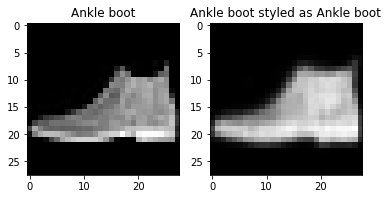

In [7]:
def plot_styled_sample(cvae, sample_image, sample_class, target_class):
    sample = cvae.predict([
        sample_image.reshape(1, 28, 28, 1), 
        np.expand_dims(unit_vector(sample_class), axis=0),
        np.expand_dims(unit_vector(target_class), axis=0)
    ])[0].reshape(28, 28)
    
    plt.subplot(1, 2, 1)
    plt.title("%s" % fashion[sample_class])
    plt.imshow(sample_image.reshape(28, 28), cmap='gray');
    plt.subplot(1, 2, 2)
    plt.title("%s styled as %s" % (
        fashion[target_class], fashion[sample_class]
    ))
    plt.imshow(sample, cmap='gray');

plot_styled_sample(cvae, test_X[0], test_y[0], 9);

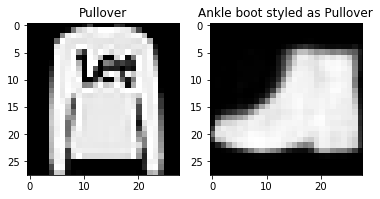

In [8]:
plot_styled_sample(cvae, test_X[1], test_y[1], 9);

Сложный конечно вопрос теперь - зачем, кроме вдохновения? Вообще, вот изображения здесь выбраны исходя исключительно из наглядности.

*CVAE* позволяют создавать **несуществующие ситуации при заданных режимах** - вот что важно. Вместо одежды могут быть некоторые финансовые показатели предприятия, физические величины при управлении затвором плотины, или даже котики. 

# Финальное заключение

На этом всё заканчивается. За бортом осталось очень многое, в частности из того, что в настоящий момент активно развивается:
- генеративные состязательные сети (generative adversarial networks) - когда одна сеть учится генерировать (и делает это лучше VAE) - несуществующие изображения (а вторая при этом заставляет её делать это всё лучше),
- обучение с подкреплением (reinforcement learning) - когда сеть обучается оптимизировать некоторую выгоду с учетом времени (играть в игры или на бирже),
- задачи на графах - обычно с помощью вложений. В том числе и задачи с изменением графов во времени.

Все это за пределами вводных концепций. Тем не менее, надеюсь, некоторый старт положен. 